# Quantitative Trading Strategy Using XGBoost
In this notebook, we develop a quantitative trading strategy using the XGBoost algorithm for daily trading. The goal is to predict future stock prices and make informed trading decisions based on these predictions.

We will:

- Load and preprocess the data
- Engineer relevant features
- Use Optuna for hyperparameter tuning
- Train the XGBoost model
- Backtest the trading strategy
- Evaluate the performance

# 1. Importing Libraries
First, we import all the necessary libraries for data manipulation, visualisation, modeling, and optimisation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
import optuna
import warnings
warnings.filterwarnings('ignore')

# 2. Data Loading
We load the historical stock data from an Excel file. Ensure that the data file Spain_daily_data.xlsx is available on the Desktop directory. We will use the PSG_MC sheet from the Excel file which contains price and volume data of Prosegur Compañía de Seguridad, S.A. (PSG.MC) from Spain market. You can find more detailed information using the below link.

https://finance.yahoo.com/quote/PSG.MC/key-statistics/

In [13]:
# Change the current working directory to Desktop
%cd D:\

# Now read the Excel file using the file name
df = pd.read_excel('Spain_daily_data.xlsx', sheet_name='PSG_MC')

# Drop unnecessary columns
df.drop(['Dividends', 'Stock Splits', 'Volume'], axis=1, inplace=True)

# Set 'Date' as index
df.set_index('Date', inplace=True)

# Display the first few rows
df.head()

D:\


,Open,High,Low,Close
Date,,,,
2003-07-30,0.597158,0.597158,0.582893,0.588304
2003-07-31,0.585844,0.595190,0.585844,0.589288
2003-08-01,0.604537,0.604537,0.590272,0.600110
2003-08-04,0.600109,0.603553,0.597650,0.603553
2003-08-05,0.603553,0.614866,0.590272,0.612407


# 3. Data Preprocessing
We extract additional time-based features from the index, such as the month and quarter. We also create lag features and rolling mean features to capture temporal dependencies.

python

In [3]:
df.loc[:,'quarter'] = df.index.quarter
df.loc[:,'month'] = df.index.month
df.loc[:, 'week'] = df.index.isocalendar().week
df.loc[:,'weekday'] = df.index.dayofweek


df.loc[:,'lag_1'] = df['Close'].shift(1)
df.loc[:,'lag_2'] = df['Close'].shift(2)
df.loc[:,'lag_3'] = df['Close'].shift(3)

df.loc[:,'rolling_mean_3'] = df['Close'].rolling(window=3).mean()
df.loc[:,'rolling_mean_5'] = df['Close'].rolling(window=5).mean()
df.loc[:,'rolling_mean_7'] = df['Close'].rolling(window=7).mean()



df['target'] = df['Close'].shift(-1)
df.dropna(inplace=True)

df.head()

,Open,High,Low,Close,quarter,month,week,weekday,lag_1,lag_2,lag_3,rolling_mean_3,rolling_mean_5,rolling_mean_7,target
Date,,,,,,,,,,,,,,,
2003-08-07,0.605028,0.612407,0.595191,0.600110,3,8,32,3,0.601585,0.612407,0.603553,0.604701,0.603553,0.599337,0.609947
2003-08-08,0.612407,0.612899,0.609947,0.609947,3,8,32,4,0.600110,0.601585,0.612407,0.603881,0.605520,0.602428,0.629623
2003-08-11,0.615358,0.636510,0.615358,0.629623,3,8,33,0,0.609947,0.600110,0.601585,0.613227,0.610734,0.608191,0.630607
2003-08-12,0.629623,0.636018,0.622245,0.630607,3,8,33,1,0.629623,0.609947,0.600110,0.623393,0.614374,0.612547,0.612407
2003-08-13,0.634542,0.634542,0.606504,0.612407,3,8,33,2,0.630607,0.629623,0.609947,0.624212,0.616539,0.613812,0.610439


# 4. Exploratory Data Analysis
Let's visualize the closing price over time to understand the trend and any potential patterns.

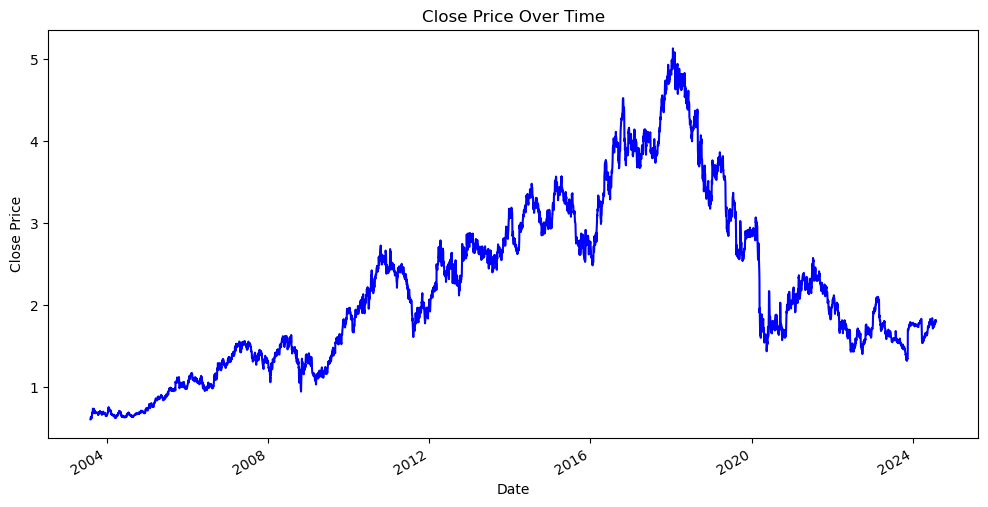

In [4]:
# Plot the Close price
plt.figure(figsize=(12,6))
df['Close'].plot(title='Close Price Over Time', color='blue')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

# 4. Hyperparameter Tuning with Optuna
We use Optuna to tune the hyperparameters of the XGBoost model.

In [ ]:
dfp = df.head(1000)
x = dfp[dfp.columns[0:-1]]
y = dfp[dfp.columns[-1]]
train_size = int(len(dfp)*0.80)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# Define the objective function
def objective(trial):
    # Suggest hyperparameters
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators',50,300),
        'max_depth': trial.suggest_int('max_depth',2,20),
        'learning_rate': trial.suggest_loguniform('learning_rate',1e-4,1.0),
        'subsample': trial.suggest_uniform('subsample',0.5,1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree',0.5,1.0),
        'alpha': trial.suggest_loguniform('alpha',1e-8,10),
        'lambda' : trial.suggest_loguniform('lambda',1e-8,10),
        'min_split_loss' : trial.suggest_int('min_split_loss',0,20),
        'min_child_weight' : trial.suggest_int('min_child_weight',0,20),
        'objective' : 'reg:squarederror'
        }
    
    # Train the model
    reg = xgb.XGBRegressor(**params)
    reg.fit(x_train,y_train,eval_set=[(x_test,y_test)], verbose=False)
    
    # Make predictions and calculate MSE
    y_pred = reg.predict(x_test)
    mse = mean_squared_error(y_test,y_pred)
    
    return mse
    

# Create a study and optimise
study = optuna.create_study(direction = 'minimize')
study.optimize(objective,n_trials=100)
print('Best hyperparameters:', study.best_params)

# 5. Rolling Time Window Model Fitting
Now we apply the rolling time window approach, where the model is retrained on the last 1000 records to predict the next time step.

In [ ]:
# Train the final model with the best parameters
j = 1000  # the length of time window
invest = 1000
perform = pd.DataFrame(columns= [f'col{i+1}' for i in range(7)],index=range(len(df)-j))
perform.columns=['current','future','predicted','return','investment','diff','resulte']
best_params = study.best_params
exp = 0
for i in range(len(df)-j):
    dff = df.iloc[i:j,:]
    print(f'The length of dataset is equal to {len(dff)}')
    split_index = int(len(dff)*0.8)
    train_dff = dff.iloc[:split_index]
    test_dff = dff.iloc[split_index:]
    X_train = train_dff[df.columns[0:-1]]
    Y_train = train_dff[df.columns[-1]]
    X_test = test_dff[df.columns[0:-1]]
    Y_test = test_dff[df.columns[-1]]
    reg = xgb.XGBRegressor(**best_params)
    reg.fit(X_train, Y_train, eval_set=[(X_test, Y_test)], verbose=100)
    prediction = reg.predict(X_test)
    prediction = pd.DataFrame(prediction,index=Y_test.index,columns=['predicted'])
    Y_test = pd.DataFrame(Y_test)
    Y_test = Y_test.join(prediction,how='inner')
    perform['current'][exp] =  X_train.iloc[-1,1]
    perform['future'][exp] = Y_test.iloc[0,0]
    perform['predicted'][exp] = Y_test.iloc[0,1]
    j+=1
    if ((perform['future'][exp]-perform['current'][exp])*(perform['predicted'][exp]-perform['current'][exp])) > 0:
        result = 'valid'
        perform['diff'][exp] = perform['future'][exp] - perform['predicted'][exp] 
        perform['return'][exp] = abs((perform['future'][exp]-perform['current'][exp])/perform['current'][exp])
        invest = invest*(1+perform['return'][exp])
        perform['investment'][exp] = invest
        perform['resulte'][exp] = 1
    else: 
        result ='invalid'
        perform['diff'][exp] = perform['future'][exp] - perform['predicted'][exp]
        perform['return'][exp] = -abs((perform['future'][exp]-perform['current'][exp])/perform['current'][exp])
        invest = invest*(1+perform['return'][exp])
        perform['investment'][exp] = invest
        perform['resulte'][exp] = 0
    print(f'the current price is {perform["current"][exp]}, the future price is {perform["future"][exp]} and the predicted price is {perform["predicted"][exp]}. Hence the result is {result}.')
    exp+=1

# Display performance results
performance.head()


# 6. Performance Evaluation
In this step, we evaluate the strategy's performance using metrics like win rate, cumulative return, and Sharpe ratio.

In [7]:
# Convert perform dataframe from object to float
perform = perform.apply(pd.to_numeric, errors='coerce')    
perform.dropna(inplace=True)
winrate = sum(perform["resulte"])/len(perform)
perform['SE'] = (perform['future']-perform['predicted'])**2
mse = sum(perform['SE'])/len(perform)
dr = perform['return'].mean()
mr = (1+dr)**21-1
ar = (1+dr)*252-1
maxreturn = perform['return'].max()
maxloss = perform['return'].min()
dsr = perform['return'].mean()/perform['return'].std()
msr = dsr*np.sqrt(21)
asr = dsr*np.sqrt(252)

print(75*'*')
print(f'The win rate of strategy is {round(winrate*100,1)} % for this asset.')
print(f"The MSE of prediction is {mse}")
print(f'Expected daily return is {round(dr*100,1)} % with probable maxim loss of {round(maxloss*100,1)} %')
print(f'Estimated monthly return is {round(mr*100,1)} with the Sharpe Retio of {round(msr,1)}')
print(75*'*')


***************************************************************************
The win rate of strategy is 72.5 % for this asset.
The MSE of prediction is 0.0047300688785597645
Expected daily return is 1.6 % with probable maxim loss of -13.0 %
Estimated monthly return is 39.4 with the Sharpe Retio of 2.5
***************************************************************************


# 7. Visualizations
7.1. Actual v.s Predicted prices

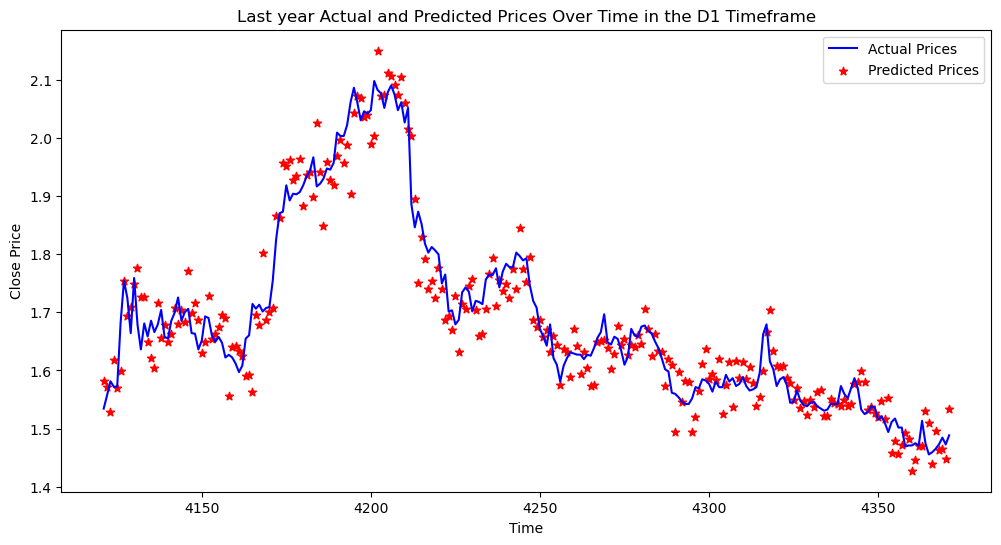

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(perform.index[-252:-1], perform['future'].iloc[-252:-1], label='Actual Prices', color='blue')
plt.scatter(perform.index[-252:-1], perform['predicted'].iloc[-252:-1], label='Predicted Prices', color='red', marker='*')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Last year Actual and Predicted Prices Over Time in the D1 Timeframe')
plt.legend()
plt.show()

7.2. Capital growth

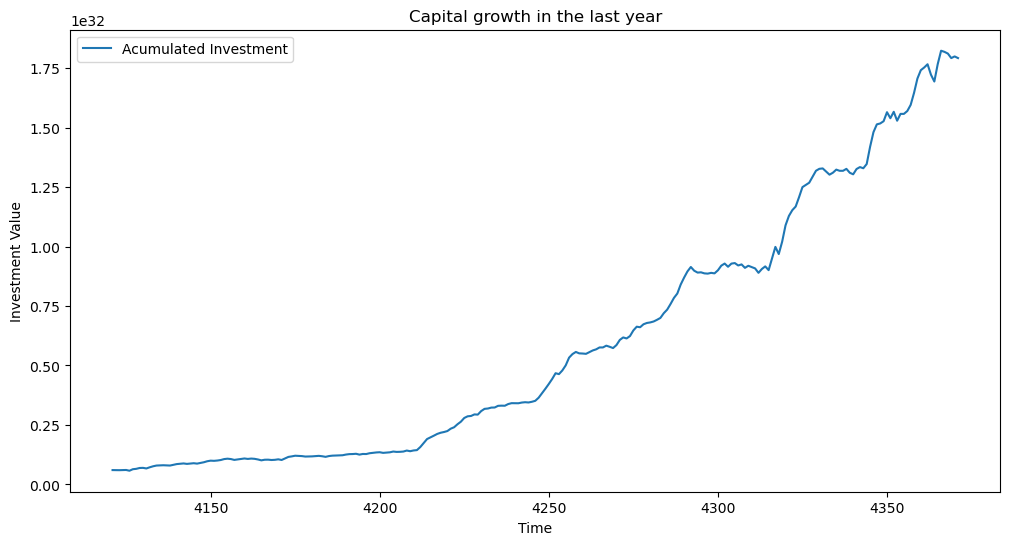

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(perform.index[-252:-1], perform.iloc[-252:-1,4], label='Acumulated Investment')
plt.xlabel('Time')
plt.ylabel('Investment Value')
plt.title('Capital growth in the last year')
plt.legend()
plt.show()

7.3. Return Distribution

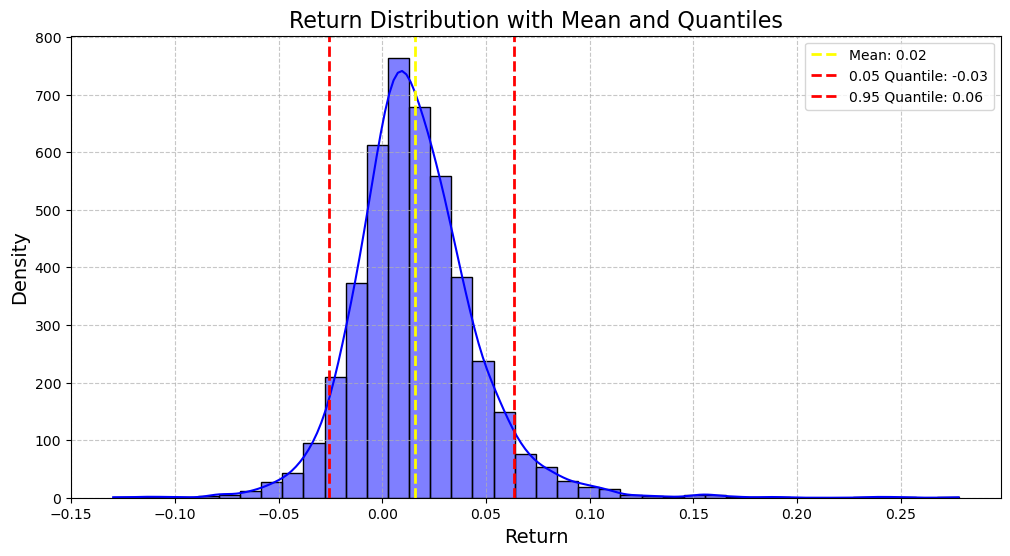

In [10]:
# Calculate statistics
mean = perform['return'].mean()
q05 = perform['return'].quantile(0.05)
q95 = perform['return'].quantile(0.95)

# Set figure size
plt.figure(figsize=(12, 6))

# Plot the histogram with KDE
sns.histplot(perform['return'], bins=40, kde=True, color='blue', edgecolor='black')

# Add vertical lines for mean, 0.05 quantile, and 0.95 quantile
plt.axvline(mean, color='yellow', linestyle='--', linewidth=2, label=f'Mean: {mean:.2f}')
plt.axvline(q05, color='red', linestyle='--', linewidth=2, label=f'0.05 Quantile: {q05:.2f}')
plt.axvline(q95, color='red', linestyle='--', linewidth=2, label=f'0.95 Quantile: {q95:.2f}')

# Add title and axis labels
plt.title('Return Distribution with Mean and Quantiles', fontsize=16)
plt.xlabel('Return', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Add legend to describe the lines
plt.legend()

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Display the plot
plt.show()

7.4. Residuals Analysis

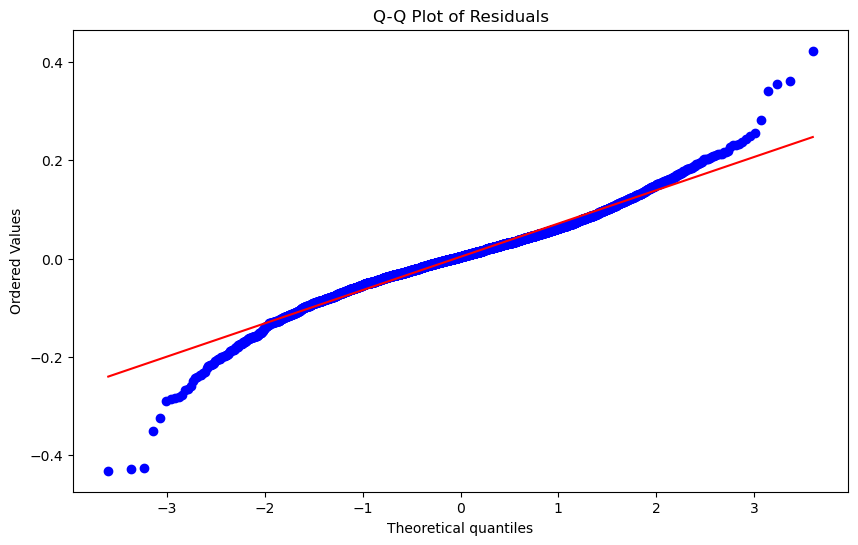

<Figure size 1000x600 with 0 Axes>

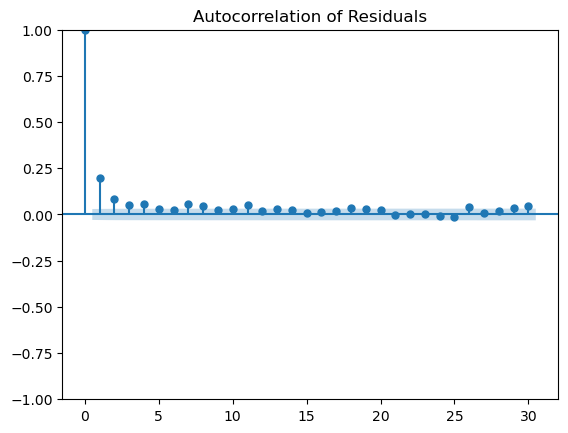

In [11]:
plt.figure(figsize=(10, 6))
stats.probplot(perform['diff'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

plt.figure(figsize=(10, 6))
plot_acf(perform['diff'], lags=30)
plt.title('Autocorrelation of Residuals')
plt.show()

7.5. Feature Importance Analysis

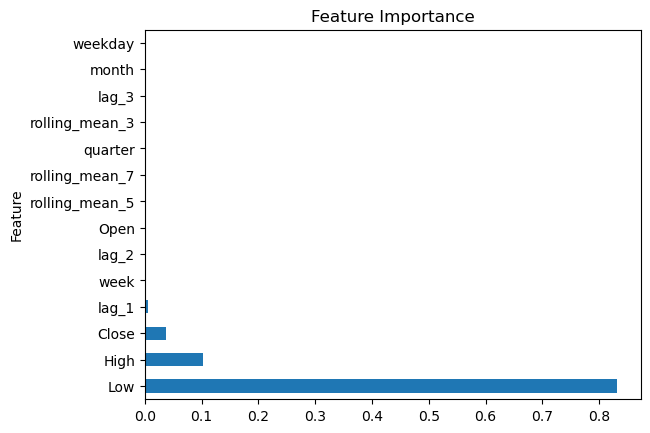

In [12]:
# Feature importance
importance = reg.feature_importances_
# Create a DataFrame for the rankings
feature_importance_df = pd.DataFrame({
    'Feature': x.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)
# Plot feature importance
feature_importance_df.plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.title('Feature Importance')
plt.show()

# 8. Conclusion
In this notebook, we implemented an XGBoost-based quantitative trading strategy with a rolling time window approach. The model was continuously retrained on the most recent data to predict future stock prices. The strategy's performance was evaluated using key metrics such as win rate, cumulative return, and Sharpe ratio.